In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

## 2 Data Set

There are two binary variables, so $2^2=4$ possible inputs.

In [7]:
binary_inputs=np.array([
                            [0.,0.],
                            [0.,1.],
                            [1.,0.],
                            [1.,1.]
                        ])
print(binary_inputs.shape)

(4, 2)


In [3]:
# define the output labels

def negate(array): #inverse every element of the array
    result = array.copy()
    for i in range(len(result)):
        result[i] = (result[i] + 1) % 2 #1+1->0 0+1->1
    return result

and_labels=np.array([0,0,0,1])
or_labels=np.array([0,1,1,1])
nand_labels=negate(and_labels)
nor_labels=negate(or_labels)
xor_labels=np.array([0,1,1,0])

print(and_labels,or_labels,nand_labels,nor_labels,xor_labels)

[0 0 0 1] [0 1 1 1] [1 1 1 0] [1 0 0 0] [0 1 1 0]


## 3 Perceptron

In [14]:

def sigmoid(value):
    return 1./(1+math.exp(-value))

def sigmoid_prime(sigmoid_value): #note that to compute sigma'(d) sigmoid_value should be sigma(d), not d
    return sigmoid_value*(1-sigmoid_value)

class Perceptron:
    def __init__(self, input_units):
        self.weights = np.random.standard_normal(size = input_units)
        self.bias = np.random.standard_normal()
        self.alpha = 0.1
    
    def forward_step(self,inputs):
        self.lastActivation = sigmoid(self.weights @ inputs + self.bias)
        self.lastInputs = inputs
        return self.lastActivation
    
    #as delta consists of the first part, the sum of all weights times the respective activation
    #and a second part, sigma'(localActivation), only the first part is computed in the previous layer
    #and given via firstHalfOfDelta
    def update(self,firstHalfOfDelta):
        
        delta = firstHalfOfDelta * sigmoid_prime(self.lastActivation) #number*number->number
        gradient = delta * self.lastInputs #number*vector->vector (compute for all weights at the same time)
        
        #deltaTimesWeights is needed by the next layer as firstHalfOfDelta
        #it is a vector and each element part of the sum for a different perceptron in the next layer
        deltaTimesWeights = self.weights * delta
        
        self.weights = self.weights - self.alpha * gradient    #vector - number * vector -> vector
        self.bias    = self.bias    - self.alpha * (delta * 1) #input for bias is always one
        
        return deltaTimesWeights
        
    
    def __str__(self): #for nicer printing of the network
        return (
            "Perceptron: Weights: " + str(self.weights) +
            ", Bias: " + str(self.bias) +
            " lastOutput: " + str(self.lastActivation)+
            '\n'
        )
    

## 4 Multi-Layer Perceptron

In [16]:
class MLP:
    
    #inputSize: how many inputs has the first layer
    #layerSizes: array of how many perceptrons are in each layer
    def __init__(self,inputSize,layerSizes):
        layers = [] # array of arrays, the latter containing perceptrons
        for l in range(0,len(layerSizes)): #for all layers...
            layer = []
            for p in range(layerSizes[l]): #...add the respective number of perceptrons to the layer
                layer.append(Perceptron(inputSize))
            
            layers.append(layer)
            inputSize = len(layer) # size of this layer is inputSize of the next layer
        
        self.layers = layers
        self.outputSize = len(layers[-1]) # size of output is size of the last layer
    
    def forward_step(self,inputs):
        for layer in self.layers:
            outputs = np.zeros(len(layer))
            for p in range(len(layer)):
                perceptron = layer[p]
                outputs[p] = perceptron.forward_step(inputs)
            inputs = outputs # outputs of this layer are inputs for the next layer
        self.outputs = outputs
        return outputs

    #errors: np-array, should contain the error for each output-perceptron (in our case one perceptron, one value)
    def backprop_step(self,errors):
        firstHalfOfDeltas = errors #the multiplication with sigma'(d) is done in the perceptrons
        for l in range(len(self.layers)-1,-1,-1): #over all layers, starting from the end
            layer = self.layers[l]
            
            #for each perceptron in the next layer: update the respective value in nextFirstHalfOfDeltas
            #nextFirstHalfOfDeltas will contain all sums of weight*delta that are necessary for the next layer
            nextFirstHalfOfDeltas = np.zeros(len(layer[0].weights)) 
            
            for p in range(len(layer)):
                perceptron=layer[p]
                
                #update returns an array of all its weights times its delta,
                #each of these values is needed by a differnt perceptron in the next layer
                nextFirstHalfOfDeltas += perceptron.update(firstHalfOfDeltas[p])
            firstHalfOfDeltas=nextFirstHalfOfDeltas
                
    def __str__(self): #for nicer printing of the network
        result = "MLP:\n"
        for i in range(len(self.layers)):
            result += "Layer " + str(i+1) + '\n'
            for neuron in self.layers[i]:
                result += str(neuron)
        return result
            
    

## 5&6 Training&Visualization

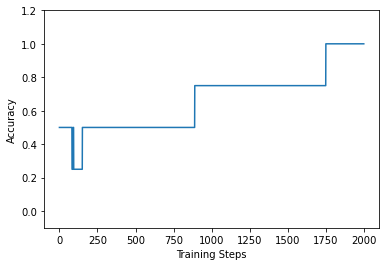

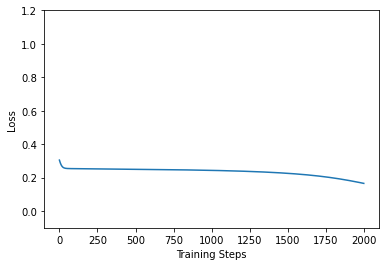

MLP:
Layer 1
Perceptron: Weights: [0.61078746 0.42404925], Bias: -0.2446589923793767 lastOutput: 0.6889362835356319
Perceptron: Weights: [-1.87620983 -2.14157681], Bias: -0.12167261503385868 lastOutput: 0.01566573805666163
Perceptron: Weights: [2.10975958 2.13063252], Bias: -3.615725661954186 lastOutput: 0.6474571904795345
Perceptron: Weights: [0.53435702 0.64335202], Bias: 1.0402275220559867 lastOutput: 0.9020019931551015
Layer 2
Perceptron: Weights: [ 0.86881455 -2.51891947 -2.77817504  0.73116451], Bias: 0.05221391711331747 lastOutput: 0.3766043969267902



In [18]:
def training(layerSizes,epochNumber,data,labels):
    network = MLP(len(data[0]),layerSizes) #the length of a datapoint equals the input-size for the first layer
    avgLosses = []
    accuracies = []
    for epoch in range(epochNumber):
        correctClassified = 0
        totalLoss = 0.
        for dp in range(len(training_inputs)):
            outputs = network.forward_step(training_inputs[dp])
            network.backprop_step(np.array([outputs[0] - labels[dp]]))
            if (outputs[0] > 0.5 and labels[dp] == 1 or 
                outputs[0] < 0.5 and labels[dp] == 0):                
                correctClassified += 1
            loss=(outputs[0]-labels[dp]) ** 2 #use the squared loss for printing
            totalLoss += loss 
        avgLosses.append(totalLoss / len(labels))
        accuracies.append(float(correctClassified) / len(labels))
    
    plt.figure()
    plt.plot(list(range(epochNumber)), accuracies)
    plt.xlabel("Training Steps")
    plt.ylabel("Accuracy")
    plt.ylim([-0.1, 1.2])
    plt.show()
    plt.figure()
    plt.plot(list(range(epochNumber)), avgLosses)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.ylim([-0.1, 1.2])
    plt.show()
    
    print(network)

#change the last variable to xy_labels to test other tasks.
#especially when training for xor, execute the program several times, if you didn't got perfect accuracy
#you can also enlarge the network by adding layers (add numbers to the list) or change their sizes with the first variable
training([4,1],2000,binary_inputs,xor_labels)